# An animation demo

Matplolib gives us two ways to make animations:
- [FuncAnimation](https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation) which makes an animation by repeatedly calling a function func, and
- [ArtistAnimation](https://matplotlib.org/api/_as_gen/matplotlib.animation.ArtistAnimation.html#matplotlib.animation.ArtistAnimation) which is an animation using a fixed set of Artist objects.

In this notebook, we look at `FuncAnimation` as an example.

**Nota Bene** these examples need `%matplolib notebook` or `%matplotlib nbagg` enabled _instead of_ `%matplotlib inline` in order to render in the notebook.

In [1]:
# set the matplolib backend to use
#%matplotlib inline
%matplotlib notebook
#%matplotlib nbagg
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math

## Example from the Documentation

Here is a [link to the documentation](https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation) for quick reference.

### Rain simulation

Modified from source: [Rain simulation](https://matplotlib.org/gallery/animation/rain.html#sphx-glr-gallery-animation-rain-py)

Author: Nicolas P. Rougier

<IPython.core.display.Javascript object>


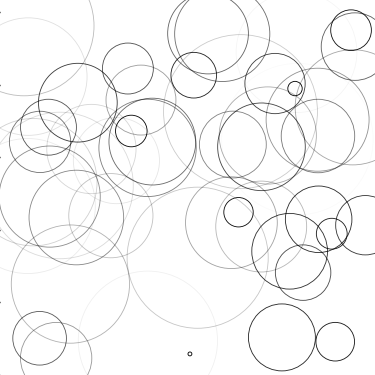

In [2]:
# Fixing random state for reproducibility
np.random.seed(42)

# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(3, 3))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)

# Create rain data
n_drops = 50
rain_drops = np.zeros(n_drops, dtype=[('position', float, 2),
                                      ('size',     float, 1),
                                      ('growth',   float, 1),
                                      ('color',    float, 4)])

# Initialize the raindrops in random positions and with
# random growth rates.
rain_drops['position'] = np.random.uniform(0, 1, (n_drops, 2))
rain_drops['growth'] = np.random.uniform(50, 200, n_drops)

# Construct the scatter which we will update during animation
# as the raindrops develop.
scat = ax.scatter(rain_drops['position'][:, 0], rain_drops['position'][:, 1],
                  s=rain_drops['size'], lw=0.5, edgecolors=rain_drops['color'],
                  facecolors='none')

def update(frame_number):
    # Get an index which we can use to re-spawn the oldest raindrop.
    current_index = frame_number % n_drops

    # Make all colors more transparent as time progresses.
    rain_drops['color'][:, 3] -= 1.0/len(rain_drops)
    rain_drops['color'][:, 3] = np.clip(rain_drops['color'][:, 3], 0, 1)

    # Make all circles bigger.
    rain_drops['size'] += rain_drops['growth']

    # Pick a new position for oldest rain drop, resetting its size,
    # color and growth factor.
    rain_drops['position'][current_index] = np.random.uniform(0, 1, 2)
    rain_drops['size'][current_index] = 5
    rain_drops['color'][current_index] = (0, 0, 0, 1)
    rain_drops['growth'][current_index] = np.random.uniform(50, 200)

    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_edgecolors(rain_drops['color'])
    scat.set_sizes(rain_drops['size'])
    scat.set_offsets(rain_drops['position'])


# Construct the animation, using the update function as the animation director.
animation = FuncAnimation(fig, update, interval=10)
plt.show()

## Deconstructing the code

What are the moving parts in the example above?

First it should be noted from the [docs](https://matplotlib.org/api/animation_api.html) that:
>[...] it is critical to keep a reference to the instance object. The animation is advanced by a timer (typically from the host GUI framework) which the Animation object holds the only reference to. If you do not hold a reference to the Animation object, it (and hence the timers), will be garbage collected which will stop the animation.

This is achieved in the _rain simulation_ example by saving the `fig` object which is passed to the `FuncAnimation()` function.

In this example, the `FuncAnimation()` function takes three arguments:

`animation = FuncAnimation(fig, update, interval=10)`

1. `fig` which is the matplotlib figure object
2. an `update` function that will be repeatedly called
3. a keyword argument `interval` specifiying the delay between frames in milliseconds

## An example from scratch

We first define a function to get points on the perimeter of a circle:

In [3]:
def perimeter(radius=1,n_points=36):
    """for a given radius r, calculate the coordinates of n points on the perimeter of a circle"""
    points = []
    for point in range(0,n_points):
        x = math.cos(2 * math.pi / n_points * point) * radius
        y = math.sin(2 * math.pi / n_points * point) * radius
        points.append((x,y))
    
    return np.array(points)

We then build a matplotlib plot (this must be done for the animation to work; the plot must be created once):

<IPython.core.display.Javascript object>


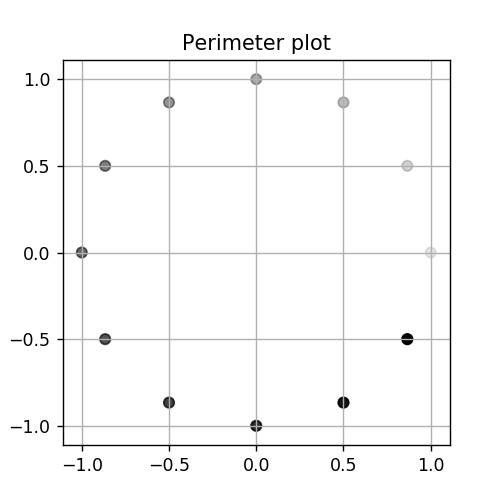

In [4]:
radius, n_points = 1, 12
x = perimeter(radius,n_points)[:,0]
y = perimeter(radius,n_points)[:,1]

fig, ax = plt.subplots(figsize=(4,4), ncols=1)

alphas = np.linspace(0.1, 1, n_points)
rgba_colors = np.zeros((n_points,4))
rgba_colors[:, 3] = alphas

ax.scatter(x,y, color=rgba_colors)
ax.set_xticks(np.array(range(-10,11,5)) / 10)
ax.set_yticks(np.array(range(-10,11,5)) / 10)
ax.grid()
ax.set_title(f'Perimeter plot')

plt.show()

Now we have this, we can save this plot initialization into a function:

In [5]:
def initialize_plot(radius, n_points):
    """
    initialize a matplotlib plot of given radius with
    n_points regularly spaced along its perimeter
    """
    # Set plot ticks
    ticks = np.array(range(-10,11,5)) / 10

    # Create new Figure and Axis
    fig, ax = plt.subplots(figsize=(4,4), ncols=1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_title(f'Perimeter plot')
    ax.grid()

    # Create x, y points
    x = perimeter(radius, n_points)[:,0]
    y = perimeter(radius, n_points)[:,1]

    # Initialize alphas and rgba colors
    alphas = np.linspace(0.1, 1, n_points)
    rgba_colors = np.zeros((n_points,4))
    rgba_colors[:, 3] = alphas

    # Construct the scatter which we will update during animation
    scat = ax.scatter(x, y, c=rgba_colors)
    
    return fig, scat

It's now time to build the function that will be called repeatedly by `FuncAnimation`, we use `np.roll()` to [_roll_](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.roll.html) the alphas array at each time step and use this to set the point sizes too:

In [6]:
def rotate(frame_number, scat, alphas):
    """
    rotates the alpha linspace, resets the rgba_colors,
    sets facecolors and sizes to scat
    
    returns updated scat
    """
    alphas = np.roll(alphas,frame_number)
    rgba_colors[:, 2] = alphas
    size = alphas
    # Update the scatter collection, with the new colors
    scat.set_facecolors(rgba_colors)
    scat.set_sizes(alphas * 300)
    
    return scat

We can now call `initialize_plot()` and save it to `(fig, scat)` and then save `FuncAnimation()` to a `name` and pass it `fig`, the `rotate()` function and the requirted `fargs` (see [docs](https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation))

<IPython.core.display.Javascript object>


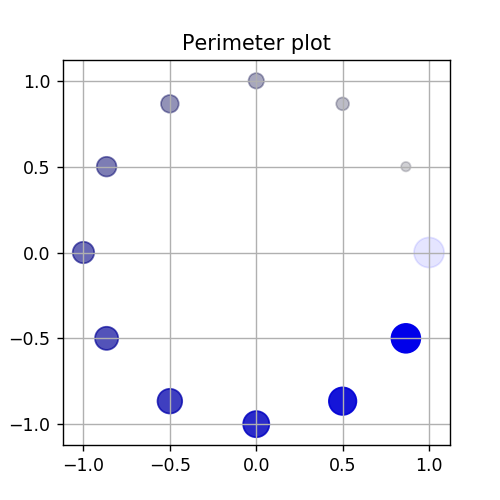

In [7]:
# Initialize the figure
fig, scat = initialize_plot(radius=1, n_points=12)

# Construct the animation, using the rotate function as the animation director.
anim = FuncAnimation(fig, rotate, fargs=[scat, alphas], interval=150, blit=True)
plt.show()

We can now save this animated plot to a \*.gif for example:

In [8]:
anim.save('rolling_points.gif', writer='imagemagick', fps=30)

## A subsurface example

An animated Ricker wavelet

In [9]:
from bruges.filters import ricker

<IPython.core.display.Javascript object>


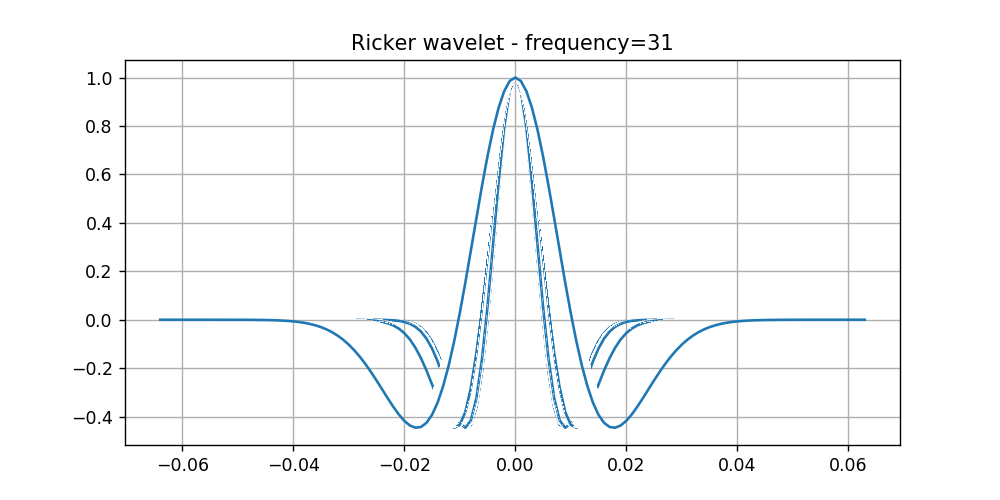

In [13]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=1)

duration, dt, frequency = 0.128, 0.001, 25
freqs_up = np.arange(20,50,1)
freqs_down = np.array(sorted(freqs_up, reverse=True))
freqs = np.append(freqs_up, freqs_down)

w, t = ricker(duration=duration, dt=dt, f=frequency, return_t=True)

line, = ax.plot(t, w)

def init():
    line.set_xdata(t)
    line.set_ydata(w)
    ax.grid()

    return line,

def animate(frame):
    frequencies = np.roll(freqs, frame)
    frequency = frequencies[0]
    
    w, t = ricker(duration=duration, dt=dt, f=frequency, return_t=True)

    line.set_xdata(t)
    line.set_ydata(w)
    
    ax.set_title(f'Ricker wavelet - frequency={frequency}')
    
    return line,

rick_ani = FuncAnimation(fig, animate, init_func=init, interval=100, blit=True)

plt.show()

In [11]:
rick_ani.save('ricker_frequencies.gif', writer='imagemagick', fps=30)

An animated seismic cube

<IPython.core.display.Javascript object>


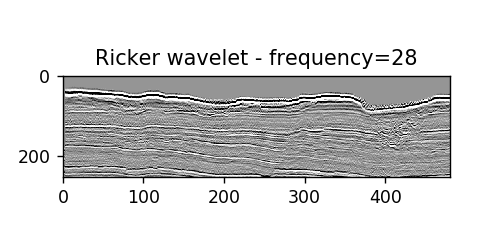

In [15]:
fig, ax = plt.subplots(figsize=(4, 2), ncols=1)

vol = np.load('../data/Penobscot_0-1000ms.npy')
ma = np.percentile(vol, 98)
inline = 300

im = ax.imshow(vol[inline,:,:].T, aspect=0.5, vmin=-ma, vmax=ma, cmap='Greys')

def seis_init():
    im.set_data(vol[inline,:,:].T, aspect=0.5, vmin=-ma, vmax=ma, cmap='Greys')
    im.colorbar(im, ax=ax, shrink=0.5).set_label('Greys')   
    
    return im
    
def seis_animate(frame):
    inline_range = np.arange(0, 600, 1)
    inlines = np.roll(inline_range, frame)
    inline_ = inlines[0]
    
    im.colorbar(im, ax=ax, shrink=0.5).set_label('Greys') 
    im.set_title(f'Penobscot_0-1000ms inline: {inline}')
    im.set_data(vol[inline_,:,:].T)
    
    return im

seis_anim = FuncAnimation(fig, seis_animate, init_func=seis_init, interval=100, blit=True)

plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2019</p>
</div>